In [ ]:
#install openslide
!apt update && apt install -y openslide-tools
!pip install openslide-python

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#sklearn data split
from sklearn.model_selection import StratifiedShuffleSplit 
from matplotlib import pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as D
import torchvision.transforms as transforms
from torch import nn
import shutil

In [27]:
#check train.csv
Dataset = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
Dataset

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
10613,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative
10614,ffe236a25d4cbed59438220799920749,radboud,2,3+4


In [ ]:
#test dataset is too small (consider only split train dataset to(training:60%,testing:20%,validation:20%))
testDataset = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
testDataset

In [ ]:
#check if dataset contains any null value (no null value)
Dataset.isnull().sum()

In [ ]:
import seaborn as sns
#visualize gleason score data
glsply = sns.countplot(x='gleason_score',data=Dataset,color='dodgerblue') 
glsply.set(xlabel = None)
glsply.set(title='gleason score')
glsply.tick_params(axis='x', rotation=30)

In [ ]:
#check how many classes are in isUp grade(6 classes)
isUp_grade= Dataset.isup_grade.unique()
print('Classes in isUp grade: ',len(isUp_grade),'\n')
print(Dataset.isup_grade.value_counts())

In [ ]:
glsply = sns.countplot(x='isup_grade',data=Dataset,color='green') 
glsply.set(xlabel = None)
glsply.set(title='isUp grade')
#glsply.tick_params(axis='x', rotation=30)

In [ ]:
glsply = sns.countplot(x='data_provider',data=Dataset) 
glsply.set(xlabel = None)
glsply.set(title='Data Provider')

In [ ]:
'''
check what is gleason score when isUp grade is 0 
(when isUpgrade == 2, 4+3 maybe a misdiagnosis)
(to see if we need to remove it)
'''
for i in range(6):
    print('isUp grade = '+str(i)+': ')
    print(Dataset.loc[Dataset.isup_grade == i,'gleason_score'].value_counts())
    print()

In [28]:
#check how many classes are in gleason score (11 classes)
gleason_score = Dataset.gleason_score.unique()
print('Classes in gleason score: ',len(gleason_score),'\n')
print(Dataset.gleason_score.value_counts())

Classes in gleason score:  11 

3+3         2666
0+0         1925
3+4         1342
4+3         1243
4+4         1126
negative     967
4+5          849
5+4          248
5+5          127
3+5           80
5+3           43
Name: gleason_score, dtype: int64


In [ ]:
#check how many cases are in dataset
print('Number of cases: ',len(Dataset))
#check how many images are in train_image and train_label_masks folder
train_path = '../input/prostate-cancer-grade-assessment/train_images'
mask_path = '../input/prostate-cancer-grade-assessment/train_label_masks'

train_image = 0
for path in os.listdir(train_path):
    if os.path.isfile(os.path.join(train_path, path)):
        train_image += 1
print('Number of train image: ',train_image)

mask_image = 0
for path in os.listdir(mask_path):
    if os.path.isfile(os.path.join(mask_path, path)):
        mask_image += 1
print('Number of mask image: ',mask_image)

In [ ]:
#check some images
#1.select 2 cases per gleason score class
TempImageDataset = pd.DataFrame()
for i in range(len(gleason_score)):
    TempImageDataset = TempImageDataset.append(Dataset.loc[Dataset.gleason_score == gleason_score[i]][:2])
TempImageDataset.reset_index()

In [ ]:
#check images using openslide
def plotImageAndmasks(TempImageDataset):
    fig = plt.figure(figsize=(40, 70))
    rows = 11
    columns = 4
    k = 1
    for i in range(len(TempImageDataset)):
        #get each image id
        image_id = TempImageDataset.iloc[i]['image_id']
        #read image
        img = openslide.OpenSlide('../input/prostate-cancer-grade-assessment/train_images/'+str(image_id)+'.tiff')
        #print('Number of image levels: ',img.level_count)#----3
        #print('dimensions of levels: ',img.level_dimensions)#----((27648, 29440), (6912, 7360), (1728, 1840))
        img = img.read_region((0, 0), img.level_count-1, img.level_dimensions[2]).convert('RGB')
        fig.add_subplot(rows, columns, k)
        #plt.axis('off')
        plt.title('isUp_grade: '+str(TempImageDataset.iloc[i]['isup_grade'])+
                  ' gleason_score: '+str(TempImageDataset.iloc[i]['gleason_score'])+
                  '\ndata_provider: '+str(TempImageDataset.iloc[i]['data_provider']))
        k+=1
        plt.imshow(img)
        # plot corresponding masks
        #1.check if it's in mask folder
        file_exists = os.path.exists('../input/prostate-cancer-grade-assessment/train_label_masks/'+str(image_id)+'_mask.tiff')
        if file_exists == True:
            #2.load masks
            mask = openslide.OpenSlide('../input/prostate-cancer-grade-assessment/train_label_masks/'+str(image_id)+'_mask.tiff')
            mask_img = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[mask.level_count - 1]).convert(mode='RGB')
            #split image to individual bands(a copy of one of original bands (red,green,blue))
            #now mask is in red band.
            mask_img = mask_img.split()[0]
            #if the raw mode is “RGB”, then palette sequence must contain at most 768 values
            palette = [0, 0, 0, 102, 102, 102, 255, 0, 0, 0, 251, 255, 246, 255, 0, 0, 255, 8]
            palette.extend([0]*750)
            mask_img.putpalette(data=palette, rawmode='RGB')
            fig.add_subplot(rows, columns, k)
            #plt.axis('off')
            plt.title('isUp_grade: '+str(TempImageDataset.iloc[i]['isup_grade'])+
                      ' gleason_score: '+str(TempImageDataset.iloc[i]['gleason_score'])+
                      '\ndata_provider: '+str(TempImageDataset.iloc[i]['data_provider']))
            plt.imshow(mask_img)
        k+=1

plotImageAndmasks(TempImageDataset)

In [4]:
#relabel gleason score
target = []
for i in range(len(Dataset)):
    if Dataset.iloc[i]['gleason_score'] == '0+0':
        target.append(0)
    if Dataset.iloc[i]['gleason_score'] == 'negative':
        target.append(0)
    elif Dataset.iloc[i]['gleason_score'] == '3+3':
        target.append(1)
    elif Dataset.iloc[i]['gleason_score'] == '3+4':
        target.append(2)
    elif Dataset.iloc[i]['gleason_score'] == '4+3':
        target.append(3)
    elif Dataset.iloc[i]['gleason_score'] == '4+4':
        target.append(4)
    elif Dataset.iloc[i]['gleason_score'] == '3+5':
        target.append(5)
    elif Dataset.iloc[i]['gleason_score'] == '5+3':
        target.append(6)
    elif Dataset.iloc[i]['gleason_score'] == '4+5':
        target.append(7)
    elif Dataset.iloc[i]['gleason_score'] == '5+4':
        target.append(8)
    elif Dataset.iloc[i]['gleason_score'] == '5+5':
        target.append(9)

Dataset['target'] = target
Dataset

,image_id,data_provider,isup_grade,gleason_score,target
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0
...,...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,0
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,7
10613,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,0
10614,ffe236a25d4cbed59438220799920749,radboud,2,3+4,2


In [5]:
Dataset = Dataset.drop([Dataset.index[7273]])

In [6]:
tgt = Dataset['target'].unique()

In [9]:
#copy images to corresponded folders
def prepareImageFolder(tgt,Dataset):
    #create data folder
    datapath = '{}'.format('data')
    if not os.path.exists(datapath):
        os.makedirs(datapath)

    for ttype in tgt:
        newpath = 'data/{}_img'.format(ttype)
        if not os.path.exists(newpath):
            os.makedirs(newpath)

    for ttype in tgt:
        image = Dataset.loc[Dataset.target == ttype,'image_id'].to_list()
        print(len(image))
        count = 0
        for img in image:
            imagefile = str(img)+'.png'
            #check image path
            for root, dirs, files in os.walk('archive/train_images/train_images'):
                for name in files:
                    if name == imagefile:  
                        imagepath = os.path.abspath(os.path.join(root, name))

            shutil.copy(imagepath, 'data/'+str(ttype)+'_img/')
            count +=1
        print('num of img: ', count)
    print('Image Copy Finished')

prepareImageFolder(tgt,Dataset)

2892
num of img:  2892
1126
num of img:  1126
2666
num of img:  2666
1242
num of img:  1242
849
num of img:  849
1342
num of img:  1342
248
num of img:  248
127
num of img:  127
43
num of img:  43
80
num of img:  80
Image Copy Finished


In [29]:
data_dir = os.getcwd() + "/data"
#preprocess dataset
def checkDataLabel(data_dir):
    dataset = torchvision.datasets.ImageFolder(root= data_dir)
    label = []
    for data in dataset.samples:
        label.append(data[1])
    return label

data_label = checkDataLabel(data_dir)

Num of data label:  10615


In [31]:
#split dataset (train dataset 60%, test dataset 20%, val dataset 20%)
from sklearn.model_selection import StratifiedShuffleSplit
import torch

########tutorial: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html########################
def ShuffleSplit(data):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    X,Y = data.numpy(),data.numpy()
    split.get_n_splits(X, Y)
    train_data, test_data= next(split.split(X, Y))
    return train_data, test_data

def splitData(data_label):
    #split data train data:60%, test data:20% and val data:20%
    trainANDval_data,test_data = ShuffleSplit(torch.FloatTensor(data_label))
    #delete test data from data pool
    train_label = np.delete(data_label, test_data, None)
    train_data, val_data = ShuffleSplit(torch.FloatTensor(train_label))
    
    return train_data,test_data,val_data


Train Size: 6793
Test Size: 2123
Val Size: 1699


In [37]:
train_data,test_data,val_data = splitData(data_label)

print("Train Size:", train_data.shape[-1]/len(data_label)*100,'%')
print("Test Size:", test_data.shape[-1]/len(data_label)*100,'%')
print("Val Size:", val_data.shape[-1]/len(data_label)*100,'%')

Train Size: 63.99434762129063 %
Test Size: 20.0 %
Val Size: 16.005652378709375 %


In [12]:
#image transformations
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
def transformation(data):
    if data == 'train':
        transform = torchvision.transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomRotation(degrees=60),
                                                transforms.ToTensor(),
                                                transforms.Normalize(norm_mean, norm_std)])
    elif data == 'test':
        transform = torchvision.transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(norm_mean, norm_std)])
    return transform


In [ ]:
#load data function

def loadData(data_dir):
    #load data
    dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transformation('train'))
    train = torch.utils.data.sampler.SubsetRandomSampler(train_data)
    #load dataset to memory
    train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False,num_workers=1, sampler= train)

    #load data
    dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transformation('test'))
    val = torch.utils.data.sampler.SubsetRandomSampler(val_data)
    #load dataset to memory
    validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, sampler=val)

    #load data
    dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transformation('test'))
    #load dataset to memory
    test = torch.utils.data.sampler.SubsetRandomSampler(test_data)
    test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, sampler=test)
      
    return train_data_loader,validation_data_loader,test_data_loader


In [ ]:
train_data_loader,validation_data_loader,test_data_loader = loadData(data_dir)

In [42]:
#check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
#https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 6, (5,5), padding=2),
                        nn.ReLU(),
                        nn.MaxPool2d((2, 2)))
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.seq = nn.Sequential(
                nn.Linear(16*54*54, 120),
                nn.ReLU(),
                nn.Linear(120, 84),
                nn.ReLU(),
                nn.Linear(84, 10)
                )
    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(x)), (2,2))
        x = x.reshape(x.shape[0], -1)
        x = self.seq(x)
        return x


In [43]:
#load model to device
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [44]:
num_epochs = 2
#for accuracy and losses record
train_accuracy = []
Val_accuracy = []
train_losses = []
Val_losses = []

#start training
for epoch in range(num_epochs):
    train_loss = 0.0
    correct_total= 0.0
    Vcorrect_total= 0.0
    num_samples_total=0.0
    Vnum_samples_total=0.0
    valid_loss = 0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # parameter gradients to zero
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #backward
        loss.backward()
        #optimize
        optimizer.step()
        
        #accuracy for it
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        num_samples_total +=labels.size(0)
        correct_total +=correct
        train_loss += loss.item()
    
    train_losses.append(train_loss/len(train_data_loader))
    train_accuracy.append(correct_total/num_samples_total)
    
    model.eval()
    
    for val_inputs, val_labels in validation_data_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
    
        vloss = criterion(val_outputs, val_labels)
        valid_loss += vloss.item() 
        _, Vpredicted = torch.max(val_outputs, 1)
        Vcorrect = (Vpredicted == val_labels).sum().item()
        Vnum_samples_total +=val_labels.size(0)
        Vcorrect_total +=Vcorrect
        

    print('Epoch: %d' %(epoch+1))
    print('train loss: %.3f  train accuracy:%.3f  val loss: %.3f  val accuracy: %.3f ' %(train_loss/len(train_data_loader), correct_total/num_samples_total,valid_loss/len(validation_data_loader),Vcorrect_total/Vnum_samples_total))

    
    Val_losses.append(valid_loss/len(validation_data_loader))
    Val_accuracy.append(Vcorrect/Vnum_samples_total)
    

Epoch: 1
train loss: 1.558  train accuracy:0.323  val loss: 1.439  val accuracy: 0.345 
Epoch: 2
train loss: 1.444  train accuracy:0.327  val loss: 1.442  val accuracy: 0.310 


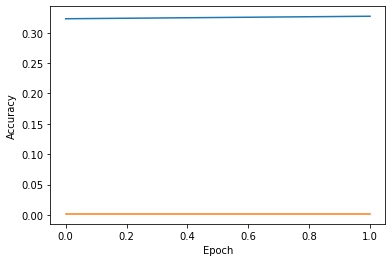

In [45]:
# MODEL EVALUATION

plt.plot(train_accuracy, label='train_accuracy')
plt.plot(Val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('train_accuracy vs val_accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_losses, label='train_loss')
plt.plot(Val_losses, label='valid_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('train_loss vs valid_loss')
plt.legend()
plt.show()

In [76]:
#gradCam part(not finished)
from collections import OrderedDict, Sequence

class GradCAM():
    def __init__(self, model):
        super(GradCAM, self).__init__(model)
        self.map = OrderedDict()
        self.grad = OrderedDict()
        
    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        if target_layer in self.map.keys():
            maps = self.map[target_layer]
        if target_layer in self.grad.keys():
            grads = self.grad[target_layer]
          
        gcam = torch.mul(maps, weights).sum(dim=1, keepdim=True)
        gcam = torch.nn.functional.relu(gcam)

        gcam = torch.nn.functional.interpolate(gcam, self.image_shape, mode="bilinear", align_corners=False)

        return gcam

In [77]:
#gradCam part(not finished)
def plotGradCam(image, model):
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["conv2"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
   
    for target_layer in target_layers:
         # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(validation_data_loader))
# Load the model
model = model
# Grad cam
plotGradCam(image[0].to(device), model)
image = np.transpose(image[0], (1,2,0))
plt.imshow(image)

TypeError: object.__init__() takes exactly one argument (the instance to initialize)